In [1]:
#pip install pmdarima

In [2]:
%matplotlib inline
import pandas as pd 
import matplotlib 
import matplotlib.pyplot as plt
import datetime
import numpy as np
from datetime import datetime, timedelta


from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from pmdarima.arima.utils import ndiffs
from pmdarima import auto_arima


In [3]:
# Database related all the code is moved to this file
%run -i "SqlConn.py"
#importing local py file
import SqlConn 

In [4]:
#Fetch only Finance Data
try:
    df_dbFinanceData = SqlConn.fetchFinanceData("twitter")
    print("Data transfer Done")
except BaseException as err:
    print(err)


Data transfer Done


In [5]:
df_dbFinanceData["date"] = pd.to_datetime(df_dbFinanceData["date"])
df_dbFinanceData.set_index("date", inplace=True)
df_dbFinanceData

,financeType,open,high,low,close,adjustedClose,volume,id
date,,,,,,,,
2013-11-07,twitter,45.099998,50.090000,44.000000,44.900002,44.900002,117701600,3031
2013-11-08,twitter,45.930000,46.939999,40.689999,41.650002,41.650002,27925300,3032
2013-11-11,twitter,40.500000,43.000000,39.400002,42.900002,42.900002,16113900,3033
2013-11-12,twitter,43.660000,43.779999,41.830002,41.900002,41.900002,6316700,3034
2013-11-13,twitter,41.029999,42.869999,40.759998,42.599998,42.599998,8688300,3035
...,...,...,...,...,...,...,...,...
2022-07-06,twitter,38.209999,38.450001,37.740002,38.209999,38.209999,4870300,5209
2022-07-07,twitter,38.320000,39.509998,38.320000,38.790001,38.790001,13214900,5210
2022-07-08,twitter,37.509998,37.549999,36.799999,36.810001,36.810001,26156700,5211


In [6]:
df_dbFinanceData.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2183 entries, 2013-11-07 to 2022-07-12
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   financeType    2183 non-null   object 
 1   open           2183 non-null   float64
 2   high           2183 non-null   float64
 3   low            2183 non-null   float64
 4   close          2183 non-null   float64
 5   adjustedClose  2183 non-null   float64
 6   volume         2183 non-null   int64  
 7   id             2183 non-null   int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 153.5+ KB


<AxesSubplot:xlabel='date'>

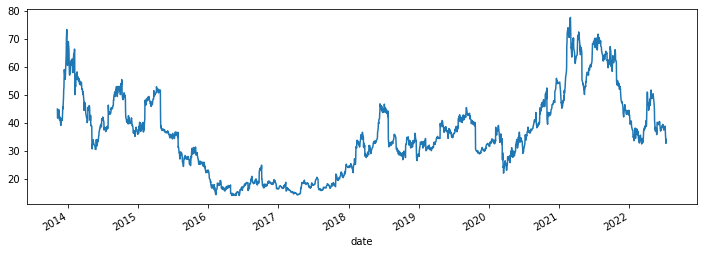

In [7]:
df_dbFinanceData['adjustedClose'].plot(figsize=(12,4))

In [8]:
df_dbFinanceData.index

DatetimeIndex(['2013-11-07', '2013-11-08', '2013-11-11', '2013-11-12',
               '2013-11-13', '2013-11-14', '2013-11-15', '2013-11-18',
               '2013-11-19', '2013-11-20',
               ...
               '2022-06-28', '2022-06-29', '2022-06-30', '2022-07-01',
               '2022-07-05', '2022-07-06', '2022-07-07', '2022-07-08',
               '2022-07-11', '2022-07-12'],
              dtype='datetime64[ns]', name='date', length=2183, freq=None)

<AxesSubplot:xlabel='date'>

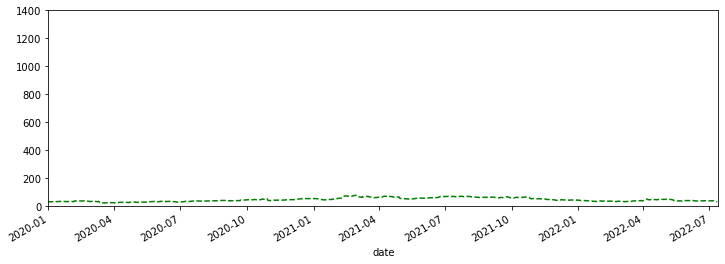

In [9]:
df_dbFinanceData['adjustedClose'].plot(xlim=['2020-01-01','2022-07-13'],ylim=[0,1400],figsize=(12,4),ls='--',c='green')

<AxesSubplot:xlabel='date'>

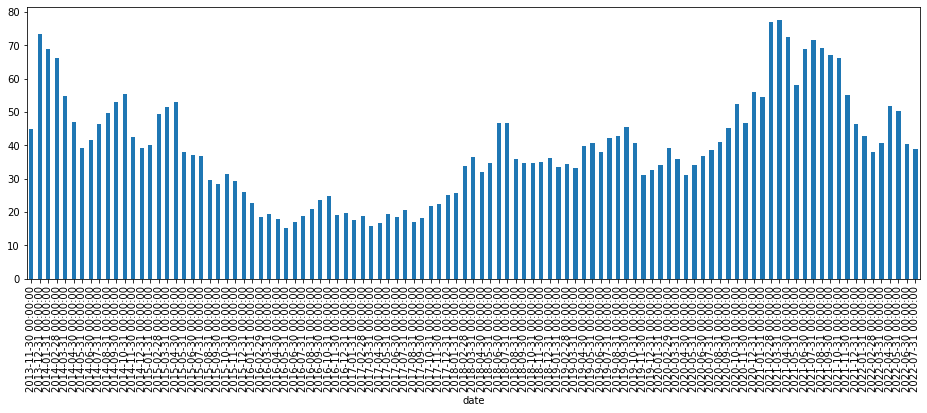

In [10]:
#Resampling to display monthly data
df_resampled = df_dbFinanceData['adjustedClose'].resample(rule='M')
df_resampled.max().plot(kind='bar',figsize=(16,5))

In [11]:
df_filteredData = df_dbFinanceData.loc['2020-01-01':'2022-7-13']
df_filteredData.index

DatetimeIndex(['2020-01-02', '2020-01-03', '2020-01-06', '2020-01-07',
               '2020-01-08', '2020-01-09', '2020-01-10', '2020-01-13',
               '2020-01-14', '2020-01-15',
               ...
               '2022-06-28', '2022-06-29', '2022-06-30', '2022-07-01',
               '2022-07-05', '2022-07-06', '2022-07-07', '2022-07-08',
               '2022-07-11', '2022-07-12'],
              dtype='datetime64[ns]', name='date', length=636, freq=None)

<AxesSubplot:xlabel='date'>

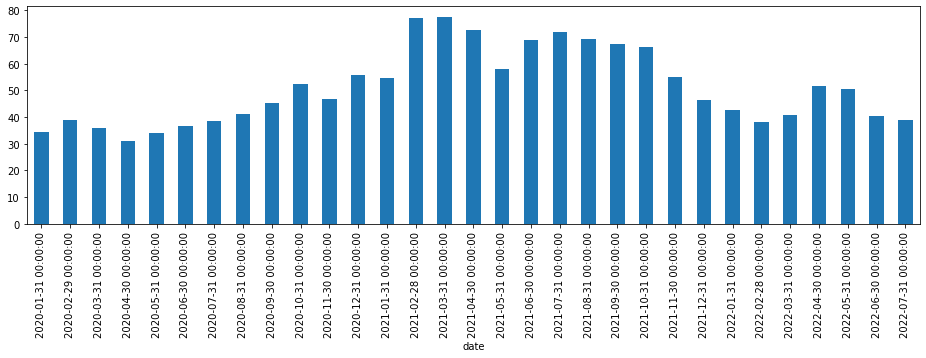

In [12]:
#Nov 2021 was the month when Tesla had highest value - checked over internet and found Nov 4 2021 was marked as highest price for Tesla stocks.
df_filteredData['adjustedClose'].resample(rule='M').max().plot(kind='bar', figsize=(16,4))

<AxesSubplot:xlabel='date'>

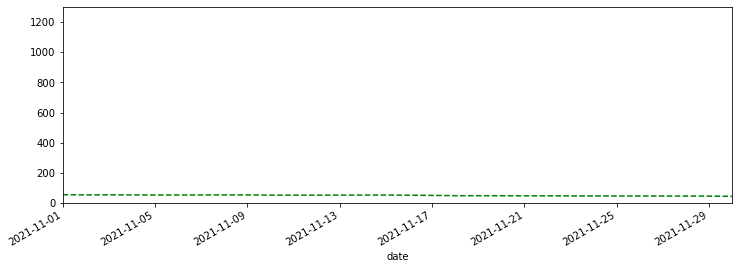

In [13]:
df_filteredData['adjustedClose'].plot(xlim=['2021-11-01','2021-11-30'],ylim=[0,1300],figsize=(12,4),ls='--',c='green')


<AxesSubplot:xlabel='date'>

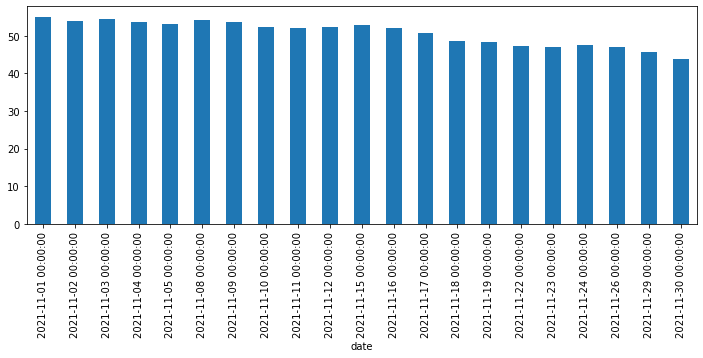

In [14]:
# checked over internet and found Nov 4 2021 was marked as highest price for Tesla stocks.
df_filteredData.loc['2021-11-01':'2021-11-30']['adjustedClose'].plot(kind='bar',figsize=(12,4))

In [15]:
#5 and 15 days rolling mean
df_dbFinanceData["adjustedClose:5 Days Rolling mean"]=df_dbFinanceData['adjustedClose'].rolling(5).mean() 
df_dbFinanceData["adjustedClose:15 Days Rolling mean"]=df_dbFinanceData['adjustedClose'].rolling(15).mean() 
df_dbFinanceData["adjustedClose:60 Days Rolling mean"]=df_dbFinanceData['adjustedClose'].rolling(60).mean() 
df_dbFinanceData

,financeType,open,high,low,close,adjustedClose,volume,id,adjustedClose:5 Days Rolling mean,adjustedClose:15 Days Rolling mean,adjustedClose:60 Days Rolling mean
date,,,,,,,,,,,
2013-11-07,twitter,45.099998,50.090000,44.000000,44.900002,44.900002,117701600,3031,NaN,NaN,NaN
2013-11-08,twitter,45.930000,46.939999,40.689999,41.650002,41.650002,27925300,3032,NaN,NaN,NaN
2013-11-11,twitter,40.500000,43.000000,39.400002,42.900002,42.900002,16113900,3033,NaN,NaN,NaN
2013-11-12,twitter,43.660000,43.779999,41.830002,41.900002,41.900002,6316700,3034,NaN,NaN,NaN
2013-11-13,twitter,41.029999,42.869999,40.759998,42.599998,42.599998,8688300,3035,42.790001,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2022-07-06,twitter,38.209999,38.450001,37.740002,38.209999,38.209999,4870300,5209,38.002000,38.258000,42.260000
2022-07-07,twitter,38.320000,39.509998,38.320000,38.790001,38.790001,13214900,5210,38.200000,38.362667,42.136000
2022-07-08,twitter,37.509998,37.549999,36.799999,36.810001,36.810001,26156700,5211,38.084000,38.284000,41.966000


<AxesSubplot:xlabel='date'>

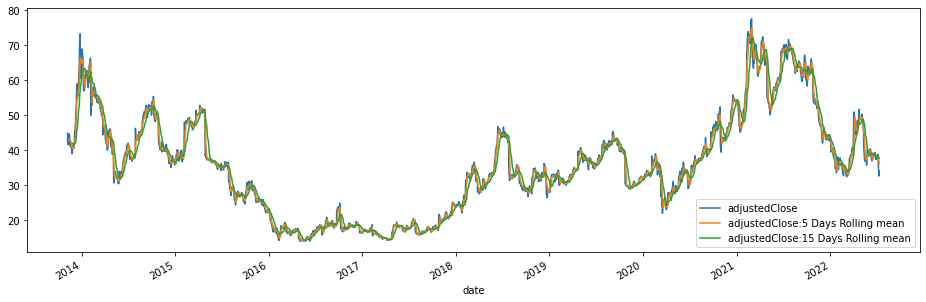

In [16]:
#smoothening the line
df_dbFinanceData[['adjustedClose','adjustedClose:5 Days Rolling mean','adjustedClose:15 Days Rolling mean']].plot(figsize=(16,5))

<AxesSubplot:xlabel='date'>

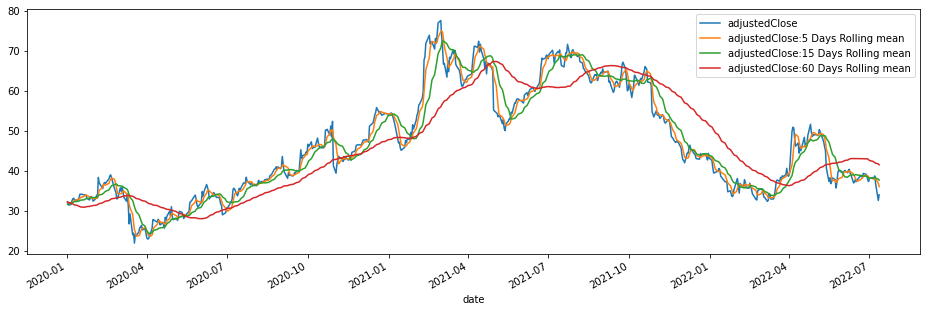

In [17]:
#smoothening the line
df_dbFinanceData.loc['2020-01-01':'2022-7-13'][['adjustedClose','adjustedClose:5 Days Rolling mean','adjustedClose:15 Days Rolling mean','adjustedClose:60 Days Rolling mean']].plot(figsize=(16,5))

#rolling mean of 5 days is closer compared to 15 days

<AxesSubplot:xlabel='date'>

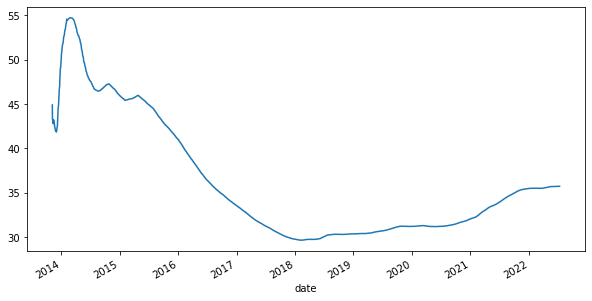

In [18]:
#Cummulative moving average
df_dbFinanceData['adjustedClose'].expanding().mean().plot(figsize=(10,5))

In [19]:
#exponential weighted moving average
df_dbFinanceData['emw0.2']=df_dbFinanceData['adjustedClose'].ewm(alpha=0.2,adjust=False).mean()
df_dbFinanceData['emw0.4']=df_dbFinanceData['adjustedClose'].ewm(alpha=0.4,adjust=False).mean()
df_dbFinanceData['emw_span5']=df_dbFinanceData['adjustedClose'].ewm(span=2,).mean()

<AxesSubplot:xlabel='date'>

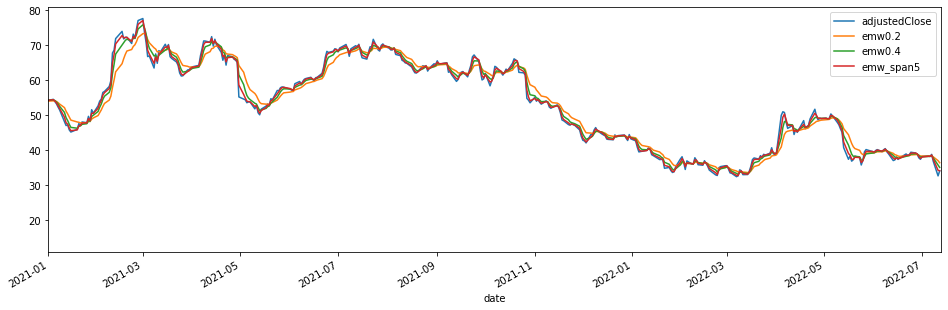

In [20]:
df_dbFinanceData[['adjustedClose','emw0.2','emw0.4','emw_span5']].plot(xlim=['2021-01-01','2022-7-13'],figsize=(16,5))

<AxesSubplot:xlabel='date'>

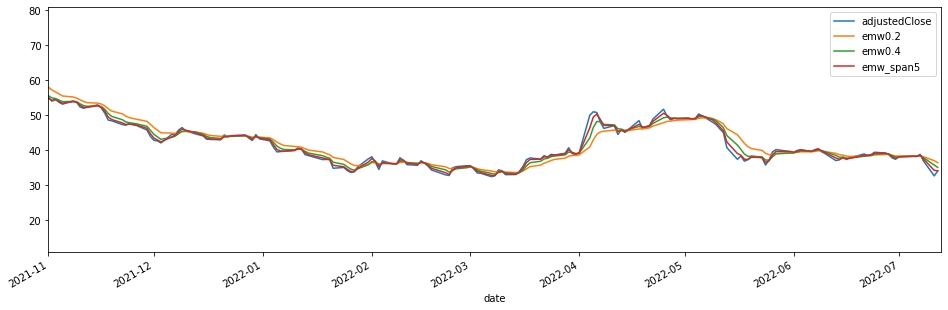

In [21]:
df_dbFinanceData[['adjustedClose','emw0.2','emw0.4','emw_span5']].plot(xlim=['2021-11-01','2022-7-13'],figsize=(16,5))

# Applying ARIMA Model

In [22]:
#Augmented Dickey–Fuller test
def adf_test(series):
    results = adfuller(series)
    print('ADF statistics: {}'.format(results[0]))
    print('P value: {}'.format(results[1]))
    if results[1] < 0.05:
        print("Ho Rejected - data is stationary")
    else:    
        print("Ho Accepted- data is not stationary")

In [23]:
adf_test(df_dbFinanceData['adjustedClose'])

ADF statistics: -2.242813431356276
P value: 0.19107504800406283
Ho Accepted- data is not stationary


In [24]:
df_dbFinanceData['adjustedClose_first_diff']=df_dbFinanceData['adjustedClose']-df_dbFinanceData['adjustedClose'].shift(1)

In [25]:
adf_test(df_dbFinanceData['adjustedClose_first_diff'].dropna())
#d=1

ADF statistics: -12.15253336550402
P value: 1.5584201247376708e-22
Ho Rejected - data is stationary


In [26]:
df_dbFinanceData

,financeType,open,high,low,close,adjustedClose,volume,id,adjustedClose:5 Days Rolling mean,adjustedClose:15 Days Rolling mean,adjustedClose:60 Days Rolling mean,emw0.2,emw0.4,emw_span5,adjustedClose_first_diff
date,,,,,,,,,,,,,,,
2013-11-07,twitter,45.099998,50.090000,44.000000,44.900002,44.900002,117701600,3031,NaN,NaN,NaN,44.900002,44.900002,44.900002,NaN
2013-11-08,twitter,45.930000,46.939999,40.689999,41.650002,41.650002,27925300,3032,NaN,NaN,NaN,44.250002,43.600002,42.462502,-3.250000
2013-11-11,twitter,40.500000,43.000000,39.400002,42.900002,42.900002,16113900,3033,NaN,NaN,NaN,43.980002,43.320002,42.765387,1.250000
2013-11-12,twitter,43.660000,43.779999,41.830002,41.900002,41.900002,6316700,3034,NaN,NaN,NaN,43.564002,42.752002,42.181252,-1.000000
2013-11-13,twitter,41.029999,42.869999,40.759998,42.599998,42.599998,8688300,3035,42.790001,NaN,NaN,43.371201,42.691200,42.461570,0.699996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-06,twitter,38.209999,38.450001,37.740002,38.209999,38.209999,4870300,5209,38.002000,38.258000,42.260000,38.301973,38.215841,38.228554,-0.170002
2022-07-07,twitter,38.320000,39.509998,38.320000,38.790001,38.790001,13214900,5210,38.200000,38.362667,42.136000,38.399579,38.445505,38.602852,0.580002
2022-07-08,twitter,37.509998,37.549999,36.799999,36.810001,36.810001,26156700,5211,38.084000,38.284000,41.966000,38.081663,37.791303,37.407618,-1.980000


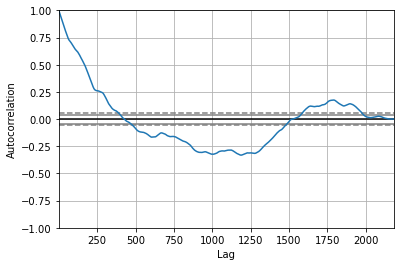

In [27]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df_dbFinanceData['adjustedClose'])
plt.show()

# Calculate AR(p), I(d), MA(q) 

In [28]:
#Estimate ARIMA differencing term,
ndiffs(df_dbFinanceData['adjustedClose'],test='adf')

1

C:\Users\15125\anaconda3\envs\PythonData\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


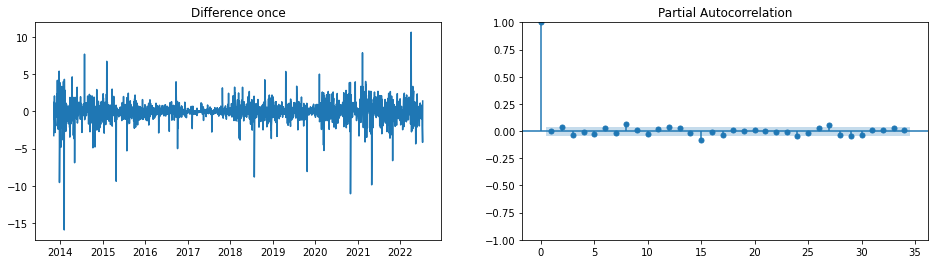

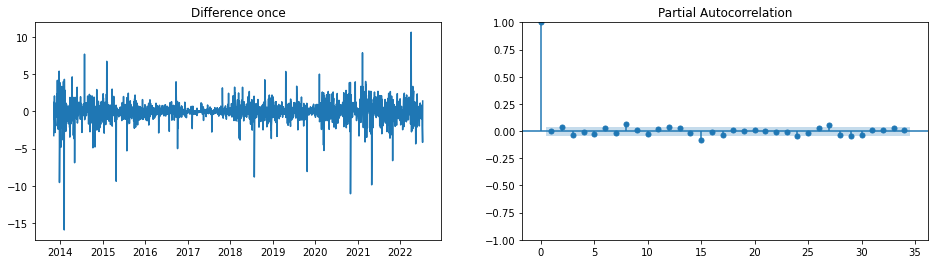

In [29]:
diff= df_dbFinanceData['adjustedClose'].diff().dropna()
fig,(ax1,ax2)=plt.subplots(1, 2, figsize=(16,4))
ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0, 1)
plot_pacf(diff, ax=ax2)
#p=3

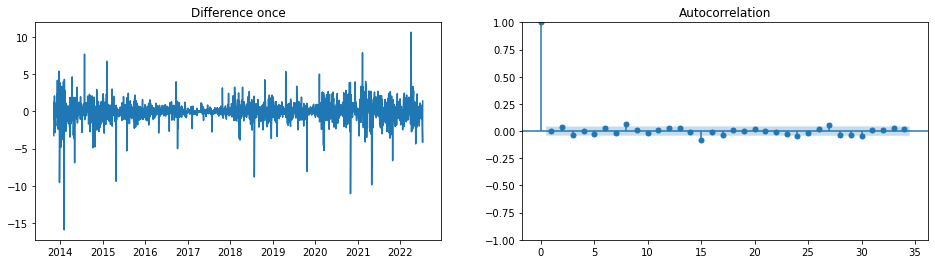

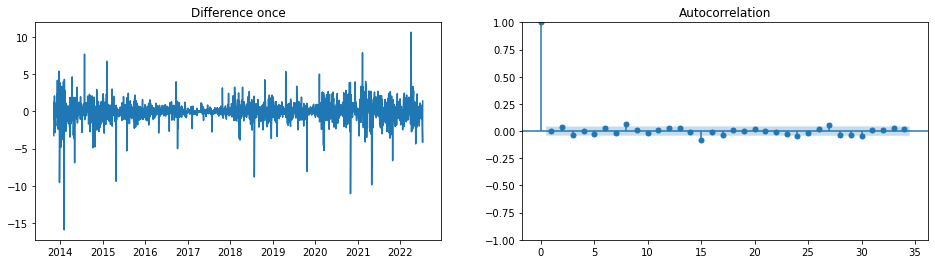

In [30]:
diff= df_dbFinanceData['adjustedClose'].diff().dropna()
fig,(ax1,ax2)=plt.subplots(1, 2, figsize=(16,4))
ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0, 1)
plot_acf(diff, ax=ax2)
#q=3

#Other ways to find P and Q

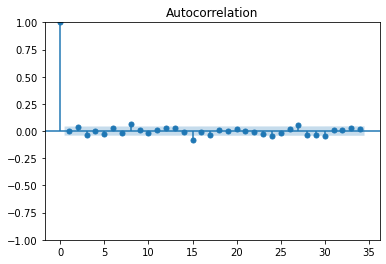

In [31]:
acf = plot_acf(df_dbFinanceData['adjustedClose_first_diff'].dropna())
#q=3

C:\Users\15125\anaconda3\envs\PythonData\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


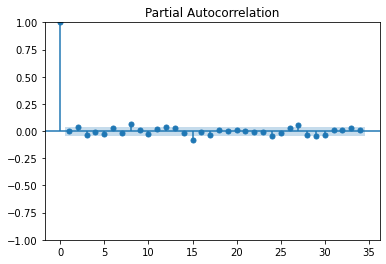

In [32]:
acf = plot_pacf(df_dbFinanceData['adjustedClose_first_diff'].dropna())
#p=3

third way to find p,d,q- using Auto_arima

In [33]:
stepwise_fit = auto_arima(df_dbFinanceData['adjustedClose'],trace=True,suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7442.553, Time=2.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7444.159, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7446.159, Time=0.31 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7446.159, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7442.189, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7440.883, Time=1.58 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7440.573, Time=3.44 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7444.838, Time=0.28 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=7445.380, Time=1.25 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7440.604, Time=1.30 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=7443.590, Time=0.51 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=4.84 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=7438.603, Time=2.28 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=7438.915, Time=0.51 sec
 ARIMA(2,1,0)(0,0,0)[0]             : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2183
Model:               SARIMAX(2, 1, 1)   Log Likelihood               -3715.301
Date:                Thu, 28 Jul 2022   AIC                           7438.603
Time:                        20:03:27   BIC                           7461.355
Sample:                             0   HQIC                          7446.920
                               - 2183                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8399      0.080    -10.479      0.000      -0.997      -0.683
ar.L2          0.0356      0.016      2.194      0.028       0.004       0.067
ma.L1          0.8432      0.080     10.492      0.000       0.686       1.001
sigma2         1.7639      0.017    102.649      0.000       1.730       1.798
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             39058.17
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.07   Skew:                            -1.38
Prob(H) (two-sided):                  0.34   Kurtosis:                        23.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Fitting the Model and Predicting

In [34]:
df_arima = df_dbFinanceData.copy()
df_arima.drop(columns=['financeType'],inplace=True)
train_dataset_end=datetime(2021,7,31)
test_dataset_end=datetime(2022,7,31)

In [35]:
train_data=df_arima[:train_dataset_end]
test_data=df_arima[train_dataset_end+timedelta(days=1):test_dataset_end]

In [36]:
##prediction
pred_start_date=test_data.index[0]
pred_end_date=test_data.index[-1]

In [37]:
train_data

,open,high,low,close,adjustedClose,volume,id,adjustedClose:5 Days Rolling mean,adjustedClose:15 Days Rolling mean,adjustedClose:60 Days Rolling mean,emw0.2,emw0.4,emw_span5,adjustedClose_first_diff
date,,,,,,,,,,,,,,
2013-11-07,45.099998,50.090000,44.000000,44.900002,44.900002,117701600,3031,NaN,NaN,NaN,44.900002,44.900002,44.900002,NaN
2013-11-08,45.930000,46.939999,40.689999,41.650002,41.650002,27925300,3032,NaN,NaN,NaN,44.250002,43.600002,42.462502,-3.250000
2013-11-11,40.500000,43.000000,39.400002,42.900002,42.900002,16113900,3033,NaN,NaN,NaN,43.980002,43.320002,42.765387,1.250000
2013-11-12,43.660000,43.779999,41.830002,41.900002,41.900002,6316700,3034,NaN,NaN,NaN,43.564002,42.752002,42.181252,-1.000000
2013-11-13,41.029999,42.869999,40.759998,42.599998,42.599998,8688300,3035,42.790001,NaN,NaN,43.371201,42.691200,42.461570,0.699996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-26,71.250000,71.250000,67.470001,68.690002,68.690002,29185100,4971,69.486001,68.828667,61.246833,69.033910,69.455118,69.427273,-3.000000
2021-07-27,68.320000,69.480003,66.860001,68.330002,68.330002,16988300,4972,69.564001,68.703334,61.465333,68.893128,69.005071,68.695759,-0.360000
2021-07-28,68.389999,71.919998,67.760002,69.959999,69.959999,23203600,4973,69.648001,68.783334,61.721667,69.106503,69.387042,69.538586,1.629997


In [38]:
test_data

,open,high,low,close,adjustedClose,volume,id,adjustedClose:5 Days Rolling mean,adjustedClose:15 Days Rolling mean,adjustedClose:60 Days Rolling mean,emw0.2,emw0.4,emw_span5,adjustedClose_first_diff
date,,,,,,,,,,,,,,
2021-08-02,70.230003,70.440002,68.660004,69.129997,69.129997,12040800,4976,69.508000,69.022667,62.513000,69.375889,69.512880,69.374761,-0.620003
2021-08-03,69.870003,70.959999,68.080002,68.629997,68.629997,9221400,4977,69.567999,68.958000,62.760333,69.226711,69.159727,68.878252,-0.500000
2021-08-04,68.680000,69.080002,67.910004,68.699997,68.699997,7578400,4978,69.315999,68.853334,63.041833,69.121368,68.975835,68.759415,0.070000
2021-08-05,68.849998,69.449997,68.080002,69.279999,69.279999,8634600,4979,69.097998,68.934000,63.315166,69.153094,69.097501,69.106471,0.580002
2021-08-06,69.300003,69.809998,66.879997,67.370003,67.370003,11458100,4980,68.621999,68.998000,63.593000,68.796476,68.406502,67.948826,-1.909996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-06,38.209999,38.450001,37.740002,38.209999,38.209999,4870300,5209,38.002000,38.258000,42.260000,38.301973,38.215841,38.228554,-0.170002
2022-07-07,38.320000,39.509998,38.320000,38.790001,38.790001,13214900,5210,38.200000,38.362667,42.136000,38.399579,38.445505,38.602852,0.580002
2022-07-08,37.509998,37.549999,36.799999,36.810001,36.810001,26156700,5211,38.084000,38.284000,41.966000,38.081663,37.791303,37.407618,-1.980000


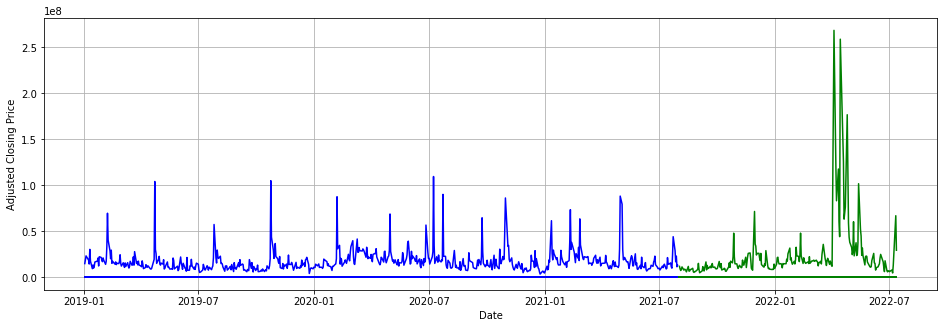

In [39]:
startdate=datetime(2019,1,1)
plt.figure(figsize=(16,5))
plt.grid(True)
plt.xlabel("Date")
plt.ylabel("Adjusted Closing Price")
plt.plot(train_data[startdate:],'blue', label="training data")
plt.plot(test_data, 'green' , label="testing data")
#plt.legend(loc="upper left")

# Train the ARIMA Model

In [40]:
model_ARIMA=sm.tsa.arima.ARIMA(df_arima['adjustedClose'],order=(3,1,3))

C:\Users\15125\anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\15125\anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\15125\anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [41]:
model_ARIMA_fit = model_ARIMA.fit()

C:\Users\15125\anaconda3\envs\PythonData\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [42]:
model_ARIMA_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          adjustedClose   No. Observations:                 2183
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -3708.970
Date:                Thu, 28 Jul 2022   AIC                           7431.940
Time:                        20:03:31   BIC                           7471.756
Sample:                             0   HQIC                          7446.495
                               - 2183                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1901      0.062      3.050      0.002       0.068       0.312
ar.L2          0.0345      0.066      0.522      0.602      -0.095       0.164
ar.L3         -0.8802      0.064    -13.804      0.000      -1.005      -0.755
ma.L1         -0.1955      0.068     -2.858      0.004      -0.330      -0.061
ma.L2         -0.0011      0.074     -0.015      0.988      -0.146       0.144
ma.L3          0.8395      0.073     11.573      0.000       0.697       0.982
sigma2         1.7545      0.020     89.256      0.000       1.716       1.793
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):             35964.12
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               1.08   Skew:                            -1.33
Prob(H) (two-sided):                  0.28   Kurtosis:                        22.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:ylabel='Density'>

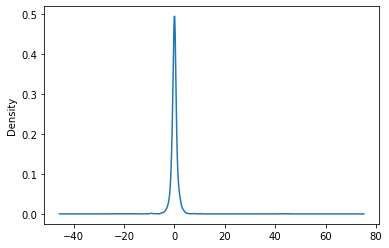

In [43]:
model_ARIMA_fit.resid.plot(kind='kde')

(array([2.27809578e-04, 2.05028620e-03, 1.60074197e-01, 3.26527062e-03,
        7.59365261e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 7.59365261e-05]),
 array([-15.42474915,  -9.39227403,  -3.35979892,   2.6726762 ,
          8.70515131,  14.73762643,  20.77010154,  26.80257666,
         32.83505177,  38.86752689,  44.900002  ]),
 <BarContainer object of 10 artists>)

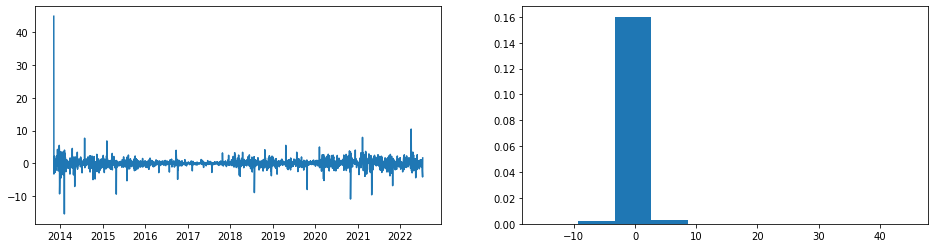

In [44]:
resids = pd.DataFrame(model_ARIMA_fit.resid)
fig, (ax1, ax2) = plt.subplots(1 ,2, figsize=(16,4))
ax1.plot(resids)
ax2.hist(resids, density=True)

In [45]:
##prediction
pred_start_date=pd.to_datetime(test_data.index[0])
pred_end_date=pd.to_datetime(test_data.index[-1])
print(pred_start_date)
print(pred_end_date)

2021-08-02 00:00:00
2022-07-12 00:00:00


In [46]:
-len(train_data)

-1945

Predicted Adjustclose Values
date
2021-08-02    69.873911
2021-08-03    68.895458
2021-08-04    68.406087
2021-08-05    68.560082
2021-08-06    69.468809
                ...    
2022-07-06    38.479707
2022-07-07    38.429614
2022-07-08    38.953284
2022-07-11    36.795568
2022-07-12    32.396002
Name: predicted_mean, Length: 238, dtype: float64


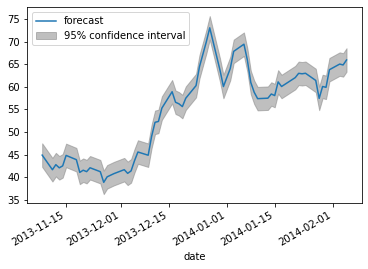

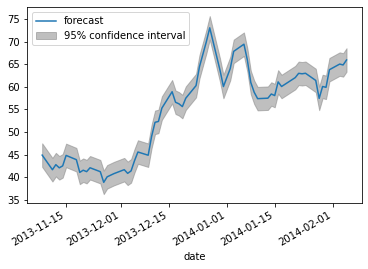

In [47]:
from statsmodels.graphics.tsaplots import plot_predict
adjustedCloseByArima_pred =model_ARIMA_fit.predict(start=len(train_data),end=(len(train_data) + len(test_data)-1)) 
adjustedCloseByArima_predictions = model_ARIMA_fit.get_prediction(start = -len(test_data))
residuals = test_data['adjustedClose']-adjustedCloseByArima_pred
print("Predicted Adjustclose Values")
print(adjustedCloseByArima_pred)
plot_predict(model_ARIMA_fit, start=1, end=60,dynamic=False)

In [48]:
df_yPred = adjustedCloseByArima_predictions.summary_frame(alpha=0.10)

# Extract prediction mean
mean_forecast = adjustedCloseByArima_predictions.predicted_mean

# Get confidence intervals of predictions
confidence_intervals = adjustedCloseByArima_predictions.conf_int()
confidence_intervals


,lower adjustedClose,upper adjustedClose
date,,
2021-08-02,67.277804,72.470019
2021-08-03,66.299351,71.491566
2021-08-04,65.809980,71.002195
2021-08-05,65.963975,71.156190
2021-08-06,66.872702,72.064917
...,...,...
2022-07-06,35.883599,41.075815
2022-07-07,35.833506,41.025722
2022-07-08,36.357176,41.549391


<AxesSubplot:xlabel='date'>

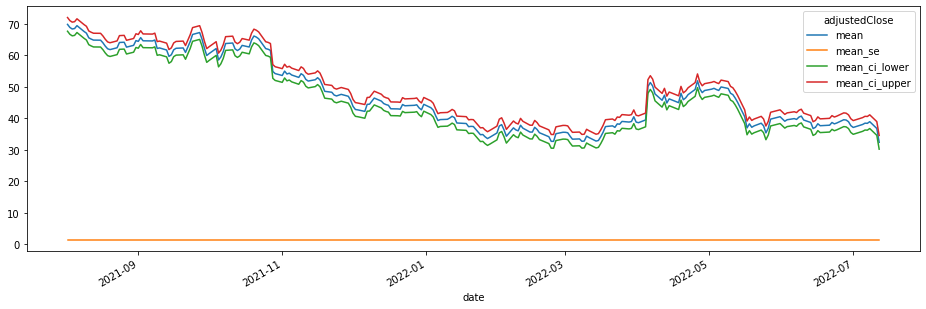

In [49]:
df_yPred.plot(figsize=(16,5))

In [50]:
d1 = pd.DataFrame(test_data['adjustedClose'])
d2 = pd.DataFrame(mean_forecast)
d2['date'] = d1.index
d2.set_index('date',inplace=True)
df_y_yPred = pd.concat([d1,d2],axis=1)

In [51]:
df_y_yPred

,adjustedClose,predicted_mean
date,,
2021-08-02,69.129997,69.873911
2021-08-03,68.629997,68.895458
2021-08-04,68.699997,68.406087
2021-08-05,69.279999,68.560082
2021-08-06,67.370003,69.468809
...,...,...
2022-07-06,38.209999,38.479707
2022-07-07,38.790001,38.429614
2022-07-08,36.810001,38.953284


<AxesSubplot:xlabel='date'>

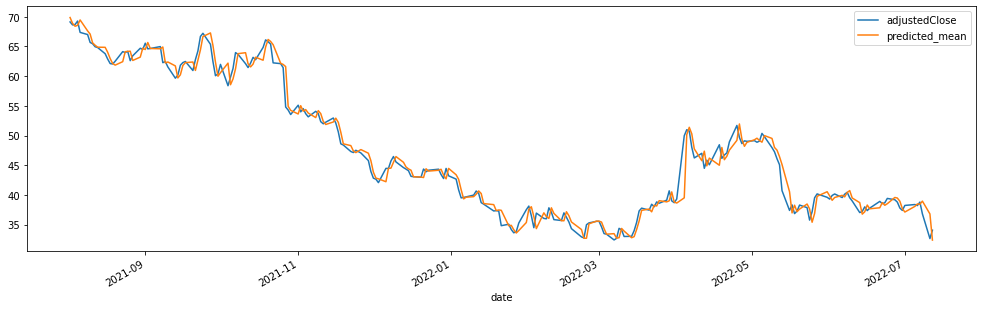

In [52]:
df_y_yPred.plot(figsize=(17,5))

# Forecasting

In [53]:
step = 30
fc = model_ARIMA_fit.forecast(step)
lst_fc = list(fc)
lst_fc

C:\Users\15125\anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[33.807195790299964,
 33.987342496976375,
 34.16872573695381,
 34.43193625335727,
 34.32965235347745,
 34.15963500754952,
 33.892111587064804,
 33.92543201421101,
 34.072188691820024,
 34.336708600385435,
 34.36271746729447,
 34.24760790248071,
 33.99379315743683,
 33.91868820113097,
 33.99697942456823,
 34.232680025928055,
 34.34628712586933,
 34.30709693142517,
 34.09610038892831,
 33.95464731026298,
 33.95497989052887,
 34.13588567834745,
 34.29478962682904,
 34.330938860036056,
 34.18405514825346,
 34.0175154868849,
 33.94897676435376,
 34.059494362823486,
 34.224725955227484,
 34.32027130579043]

In [54]:
fc

2183    33.807196
2184    33.987342
2185    34.168726
2186    34.431936
2187    34.329652
2188    34.159635
2189    33.892112
2190    33.925432
2191    34.072189
2192    34.336709
2193    34.362717
2194    34.247608
2195    33.993793
2196    33.918688
2197    33.996979
2198    34.232680
2199    34.346287
2200    34.307097
2201    34.096100
2202    33.954647
2203    33.954980
2204    34.135886
2205    34.294790
2206    34.330939
2207    34.184055
2208    34.017515
2209    33.948977
2210    34.059494
2211    34.224726
2212    34.320271
Name: predicted_mean, dtype: float64

In [55]:
import time
import datetime
from datetime import date,timedelta


end_date = pred_end_date 

date_future = end_date + datetime.timedelta(41)

df_future_dates = pd.date_range(start=end_date, end=date_future,freq='B')
df_future_dates

DatetimeIndex(['2022-07-12', '2022-07-13', '2022-07-14', '2022-07-15',
               '2022-07-18', '2022-07-19', '2022-07-20', '2022-07-21',
               '2022-07-22', '2022-07-25', '2022-07-26', '2022-07-27',
               '2022-07-28', '2022-07-29', '2022-08-01', '2022-08-02',
               '2022-08-03', '2022-08-04', '2022-08-05', '2022-08-08',
               '2022-08-09', '2022-08-10', '2022-08-11', '2022-08-12',
               '2022-08-15', '2022-08-16', '2022-08-17', '2022-08-18',
               '2022-08-19', '2022-08-22'],
              dtype='datetime64[ns]', freq='B')

In [56]:
df_future_dates

DatetimeIndex(['2022-07-12', '2022-07-13', '2022-07-14', '2022-07-15',
               '2022-07-18', '2022-07-19', '2022-07-20', '2022-07-21',
               '2022-07-22', '2022-07-25', '2022-07-26', '2022-07-27',
               '2022-07-28', '2022-07-29', '2022-08-01', '2022-08-02',
               '2022-08-03', '2022-08-04', '2022-08-05', '2022-08-08',
               '2022-08-09', '2022-08-10', '2022-08-11', '2022-08-12',
               '2022-08-15', '2022-08-16', '2022-08-17', '2022-08-18',
               '2022-08-19', '2022-08-22'],
              dtype='datetime64[ns]', freq='B')

In [57]:
df_combine = pd.DataFrame(df_future_dates,lst_fc)
df_combine.columns=['date']
df_combine

,date
33.807196,2022-07-12
33.987342,2022-07-13
34.168726,2022-07-14
34.431936,2022-07-15
34.329652,2022-07-18
34.159635,2022-07-19
33.892112,2022-07-20
33.925432,2022-07-21
34.072189,2022-07-22
34.336709,2022-07-25


In [58]:
df_combine = df_combine.reset_index()
df_combine = df_combine.set_index('date')
df_combine

,index
date,
2022-07-12,33.807196
2022-07-13,33.987342
2022-07-14,34.168726
2022-07-15,34.431936
2022-07-18,34.329652
2022-07-19,34.159635
2022-07-20,33.892112
2022-07-21,33.925432
2022-07-22,34.072189


In [59]:
df_combine.rename(columns={"index":"forecasted_mean"},inplace=True)

In [60]:
df_combine

,forecasted_mean
date,
2022-07-12,33.807196
2022-07-13,33.987342
2022-07-14,34.168726
2022-07-15,34.431936
2022-07-18,34.329652
2022-07-19,34.159635
2022-07-20,33.892112
2022-07-21,33.925432
2022-07-22,34.072189


In [61]:
test_data

,open,high,low,close,adjustedClose,volume,id,adjustedClose:5 Days Rolling mean,adjustedClose:15 Days Rolling mean,adjustedClose:60 Days Rolling mean,emw0.2,emw0.4,emw_span5,adjustedClose_first_diff
date,,,,,,,,,,,,,,
2021-08-02,70.230003,70.440002,68.660004,69.129997,69.129997,12040800,4976,69.508000,69.022667,62.513000,69.375889,69.512880,69.374761,-0.620003
2021-08-03,69.870003,70.959999,68.080002,68.629997,68.629997,9221400,4977,69.567999,68.958000,62.760333,69.226711,69.159727,68.878252,-0.500000
2021-08-04,68.680000,69.080002,67.910004,68.699997,68.699997,7578400,4978,69.315999,68.853334,63.041833,69.121368,68.975835,68.759415,0.070000
2021-08-05,68.849998,69.449997,68.080002,69.279999,69.279999,8634600,4979,69.097998,68.934000,63.315166,69.153094,69.097501,69.106471,0.580002
2021-08-06,69.300003,69.809998,66.879997,67.370003,67.370003,11458100,4980,68.621999,68.998000,63.593000,68.796476,68.406502,67.948826,-1.909996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-06,38.209999,38.450001,37.740002,38.209999,38.209999,4870300,5209,38.002000,38.258000,42.260000,38.301973,38.215841,38.228554,-0.170002
2022-07-07,38.320000,39.509998,38.320000,38.790001,38.790001,13214900,5210,38.200000,38.362667,42.136000,38.399579,38.445505,38.602852,0.580002
2022-07-08,37.509998,37.549999,36.799999,36.810001,36.810001,26156700,5211,38.084000,38.284000,41.966000,38.081663,37.791303,37.407618,-1.980000


In [62]:
test_data

,open,high,low,close,adjustedClose,volume,id,adjustedClose:5 Days Rolling mean,adjustedClose:15 Days Rolling mean,adjustedClose:60 Days Rolling mean,emw0.2,emw0.4,emw_span5,adjustedClose_first_diff
date,,,,,,,,,,,,,,
2021-08-02,70.230003,70.440002,68.660004,69.129997,69.129997,12040800,4976,69.508000,69.022667,62.513000,69.375889,69.512880,69.374761,-0.620003
2021-08-03,69.870003,70.959999,68.080002,68.629997,68.629997,9221400,4977,69.567999,68.958000,62.760333,69.226711,69.159727,68.878252,-0.500000
2021-08-04,68.680000,69.080002,67.910004,68.699997,68.699997,7578400,4978,69.315999,68.853334,63.041833,69.121368,68.975835,68.759415,0.070000
2021-08-05,68.849998,69.449997,68.080002,69.279999,69.279999,8634600,4979,69.097998,68.934000,63.315166,69.153094,69.097501,69.106471,0.580002
2021-08-06,69.300003,69.809998,66.879997,67.370003,67.370003,11458100,4980,68.621999,68.998000,63.593000,68.796476,68.406502,67.948826,-1.909996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-06,38.209999,38.450001,37.740002,38.209999,38.209999,4870300,5209,38.002000,38.258000,42.260000,38.301973,38.215841,38.228554,-0.170002
2022-07-07,38.320000,39.509998,38.320000,38.790001,38.790001,13214900,5210,38.200000,38.362667,42.136000,38.399579,38.445505,38.602852,0.580002
2022-07-08,37.509998,37.549999,36.799999,36.810001,36.810001,26156700,5211,38.084000,38.284000,41.966000,38.081663,37.791303,37.407618,-1.980000


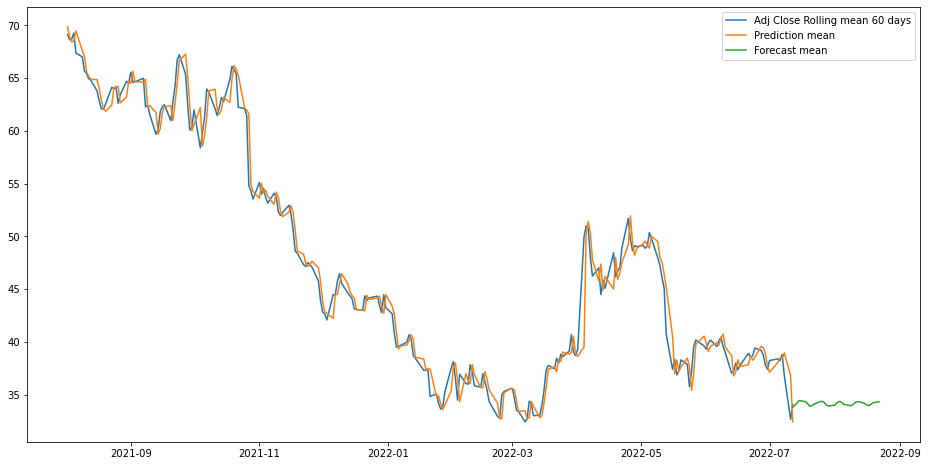

In [63]:
#plot the predictions for validation set
plt.figure(figsize=(16, 8))
plt.plot(test_data["adjustedClose"], label='Adj Close Rolling mean 60 days')
#plt.plot(valid, label='Valid')
plt.plot(df_y_yPred["predicted_mean"], label='Prediction mean')
plt.plot(df_combine["forecasted_mean"], label='Forecast mean')
plt.legend()
plt.show()

# MAE, RMSE, MAPE

In [64]:
from sklearn.metrics import mean_absolute_error
mae=mean_absolute_error(test_data["adjustedClose"],df_y_yPred["predicted_mean"])
mae
#MAE Mean of Absolute value of Errors -

1.0467771277990447

In [65]:
from sklearn.metrics import mean_absolute_percentage_error
mape =mean_absolute_percentage_error(test_data["adjustedClose"],df_y_yPred["predicted_mean"])
mape
#MEAN ABSOLUTE PERCENTAGE ERROR (MAPE) = 29.7% is the difference between Actual vs Predicted

0.02288099178225702

In [66]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(test_data["adjustedClose"],df_y_yPred["predicted_mean"]))
rmse 
#Root Mean Squared Error = 310 

1.5026693837669938

In [67]:
print("Twitter")
print("--------------")
print("MAE :" + str(mae) )
print("MAPE :" + str(mape) )
print("RMSE :" + str(rmse) )

Twitter
--------------
MAE :1.0467771277990447
MAPE :0.02288099178225702
RMSE :1.5026693837669938
